### Imports

In [1]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain.tools import tool
from langgraph.graph import MessagesState, StateGraph, START
from langchain.messages import HumanMessage
from langgraph.prebuilt import ToolNode, tools_condition

### LLM

In [2]:
load_dotenv()

groq_key = os.getenv("groq_api_key")
os.environ["GROQ_API_KEY"] = groq_key

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0
)

### Tools

In [3]:
@tool
def multiply(a: int, b: int) -> int:
    """
    Perform multiplication of two integers and return the result.
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """
    Perform addition of two integers and return the result.
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """
    Perform division of two integers and return the result.
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools)

### Nodes

In [5]:
# class ChatState(TypedDict):
#     messages: Annotated[list[BaseMessage], add_messages]

def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    response = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}


# def tool_node(state: dict):
#     """Performs the tool call"""

#     result = []
#     for tool_call in state["messages"][-1].tool_calls:
#         tool = tools_by_name[tool_call["name"]]
#         observation = tool.invoke(tool_call["args"])
#         result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
#     return {"messages": result}

tool_node = ToolNode(tools) 

# # Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
# def should_continue(state: MessagesState) -> Literal["tool_node", END]:
#     """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

#     messages = state["messages"]
#     last_message = messages[-1]

#     # If the LLM makes a tool call, then perform an action
#     if last_message.tool_calls:
#         return "tool_node"

#     # Otherwise, we stop (reply to the user)
#     return END

### Workflow

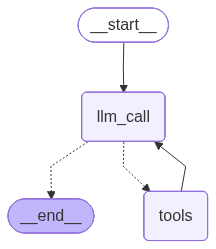

In [6]:
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tools", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
# agent_builder.add_conditional_edges(
#     "llm_call",
#     should_continue,
#     ["tool_node", END]
# )
agent_builder.add_conditional_edges("llm_call", tools_condition)
agent_builder.add_edge("tools", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Save the workflow as image
# agent.get_graph().draw_mermaid_png(output_file_path="agent_flow.png")

# Show the agent
agent

### Invoke

In [7]:
messages = [HumanMessage(content="Add 3 and 4 and then multiple by 2.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4 and then multiple by 2.
================================== Ai Message ==================================
Tool Calls:
  add (eachf89aq)
 Call ID: eachf89aq
  Args:
    a: 3
    b: 4
  multiply (j9xktqztt)
 Call ID: j9xktqztt
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: add

7
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

The result of adding 3 and 4 is 7, then multiplying 7 by 2 gives 14.


In [9]:
messages["messages"][-1].content

'The result of adding 3 and 4 is 7, then multiplying 7 by 2 gives 14.'

In [10]:
messages = [HumanMessage(content="Add 3 and 4 and then multiple by 2.")]
for node in agent.stream({"messages": messages}):
    print(node)

{'llm_call': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'cc01r00qw', 'function': {'arguments': '{"a":3,"b":4}', 'name': 'add'}, 'type': 'function'}, {'id': '28jcb5kz3', 'function': {'arguments': '{"a":7,"b":2}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 363, 'total_tokens': 399, 'completion_time': 0.070581132, 'completion_tokens_details': None, 'prompt_time': 0.035232527, 'prompt_tokens_details': None, 'queue_time': 0.049244962, 'total_time': 0.105813659}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_68f543a7cc', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c619c-61e2-7c30-b1d7-2d0ac9625ab7-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 4}, 'id': 'cc01r00qw', 'type': 'tool_call'}, {'name': 'multiply', 'args': {'a': 7, 'b': 2}, 'id': '28jcb5kz3', 'type': 'tool_call'}], inva